# Machine Learning–Based Recommendation System
### End-to-End Project by Moiz Mansoori

## Dataset Overview
We are using the `ratings.csv` dataset. 

### Column Descriptions:
- **userId**: Unique identifier for each user.
- **movieId**: Unique identifier for each movie/item.
- **rating**: The score given by the user to the movie (Target Variable).
- **timestamp**: The time when the rating was recorded.

### Recommendation Problem Type:
This is a **Rating Prediction** problem using **Collaborative Filtering**. We aim to predict the rating a user would give to an item based on historical interactions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import joblib

# Set style for plots
plt.style.use('ggplot')
sns.set_palette('viridis')

## Step 1: Data Preparation
### Loading and Cleaning

In [3]:
# Load dataset
df = pd.read_csv('ratings.csv')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate rows:", df.duplicated().sum())

# Drop timestamp as it's not needed for basic collaborative filtering
df = df.drop('timestamp', axis=1)

print("\nDataset Shape:", df.shape)
df.head()

Missing values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Duplicate rows: 0

Dataset Shape: (100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Exploratory Data Analysis (EDA)

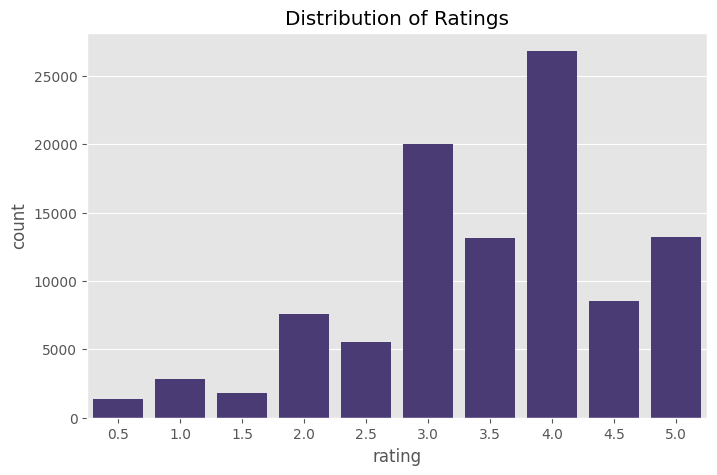

Number of Users: 610
Number of Movies: 9724
Sparsity: 98.30%


In [4]:
# Rating Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df)
plt.title('Distribution of Ratings')
plt.show()

# Sparsity Calculation
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = (1 - len(df) / (n_users * n_items)) * 100
print(f"Number of Users: {n_users}")
print(f"Number of Movies: {n_items}")
print(f"Sparsity: {sparsity:.2f}%")

### Encoding and Map Generation

In [5]:
# Mapping IDs to continuous indices for matrix operations
user_map = {id: i for i, id in enumerate(df['userId'].unique())}
movie_map = {id: i for i, id in enumerate(df['movieId'].unique())}
inv_movie_map = {i: id for id, i in movie_map.items()}

df['u_idx'] = df['userId'].map(user_map)
df['m_idx'] = df['movieId'].map(movie_map)

# Create User-Item Matrix
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_matrix = np.zeros((n_users, n_items))
for row in train_df.itertuples():
    train_matrix[row.u_idx, row.m_idx] = row.rating

# Pre-calculate Baselines for "Cold-Start" cases
global_mean = train_df['rating'].mean()
movie_averages = train_df.groupby('m_idx')['rating'].mean().to_dict()
print(f"Global Mean Rating: {global_mean:.2f}")

Global Mean Rating: 3.50


## Step 2: Training Three Different Models

We implement three models manually using `numpy` and `scikit-learn` similarity measures.

### 1. User-Based Collaborative Filtering
- **Logic**: Recommends items by finding users similar to the current user. 
- **Similiarity**: Cosine Similarity between user rating vectors.

In [6]:
user_sim = cosine_similarity(train_matrix)

def predict_user_based(u_idx, m_idx):
    # Baseline prediction if movie exists, else global mean
    baseline = movie_averages.get(m_idx, global_mean)
    
    if m_idx >= n_items or u_idx >= n_users: return baseline
    
    sim_scores = user_sim[u_idx]
    item_ratings = train_matrix[:, m_idx]
    
    # Find users who have rated this item
    idx = np.where(item_ratings > 0)[0]
    if len(idx) == 0: return baseline
    
    relevant_sims = sim_scores[idx]
    relevant_ratings = item_ratings[idx]
    
    if np.sum(np.abs(relevant_sims)) == 0: return baseline
    return np.sum(relevant_sims * relevant_ratings) / np.sum(np.abs(relevant_sims))

### 2. Item-Based Collaborative Filtering
- **Logic**: Recommends items similar to those the user has previously interacted with.
- **Similarity**: Cosine Similarity between item rating vectors (columns of matrix).

In [7]:
item_sim = cosine_similarity(train_matrix.T)

def predict_item_based(u_idx, m_idx):
    # Baseline prediction if movie exists, else global mean
    baseline = movie_averages.get(m_idx, global_mean)
    
    if m_idx >= n_items or u_idx >= n_users: return baseline
    
    sim_scores = item_sim[m_idx]
    user_ratings = train_matrix[u_idx, :]
    
    # Find items the user has already rated
    idx = np.where(user_ratings > 0)[0]
    if len(idx) == 0: return baseline
    
    relevant_sims = sim_scores[idx]
    relevant_ratings = user_ratings[idx]
    
    if np.sum(np.abs(relevant_sims)) == 0: return baseline
    return np.sum(relevant_sims * relevant_ratings) / np.sum(np.abs(relevant_sims))

### 3. Matrix Factorization (SVD)
- **Logic**: Latent factor model that decomposes the user-item matrix into components representing hidden features.

In [8]:
matrix_centered = train_matrix.copy()
mask = (matrix_centered != 0)
matrix_centered[mask] -= global_mean

U, S, Vt = np.linalg.svd(matrix_centered, full_matrices=False)
k = 20 # number of latent factors
mf_pred_matrix = np.dot(np.dot(U[:, :k], np.diag(S[:k])), Vt[:k, :]) + global_mean

def predict_svd(u_idx, m_idx):
    if u_idx < n_users and m_idx < n_items: return mf_pred_matrix[u_idx, m_idx]
    return global_mean

## Step 3: Evaluation
### Results Comparison
RMSE was chosen as the evaluation metric because it heavily penalizes large errors, which is critical for accurate rating predictions.

In [9]:
# Evaluating on a sample of the test set for efficiency
test_sample = test_df.sample(2000, random_state=42)
y_true = test_sample['rating'].values

results = []
for name, func in [('User-Based CF', predict_user_based), ('Item-Based CF', predict_item_based), ('SVD', predict_svd)]:
    y_pred = [func(r.u_idx, r.m_idx) for r in test_sample.itertuples()]
    # Clip predictions to valid rating range [0.5, 5.0]
    y_pred = np.clip(y_pred, 0.5, 5.0)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae})

results_df = pd.DataFrame(results)
print("Evaluation Results:")
display(results_df)

Evaluation Results:


,Model,RMSE,MAE
0,User-Based CF,0.984640,0.764232
1,Item-Based CF,0.924433,0.714686
2,SVD,1.013396,0.792571


## Step 4: Final Recommendation Feature
Now that we've found our best model (Item-Based CF), let's implement a function to give actual recommendations to a user.

In [10]:
def get_top_n_recommendations(user_id, n=5):
    """Generates top N movie recommendations for a given user ID."""
    if user_id not in user_map:
        return f"User {user_id} not found in database."
    
    u_idx = user_map[user_id]
    # Find movies user hasn't rated yet
    already_rated = train_matrix[u_idx, :] > 0
    unrated_m_indices = np.where(~already_rated)[0]
    
    predictions = []
    for m_idx in unrated_m_indices:
        pred = predict_item_based(u_idx, m_idx)
        predictions.append((inv_movie_map[m_idx], pred))
    
    # Sort by predicted rating descending
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    return predictions[:n]

# Example Usage: Top 5 recommendations for User 1
recommendations = get_top_n_recommendations(1, n=5)
print("\nTop 5 Recommendations for User 1:")
for movie_id, score in recommendations:
    print(f"Movie ID: {movie_id}, Predicted Rating: {score:.2f}")


Top 5 Recommendations for User 1:
Movie ID: 131724, Predicted Rating: 5.00
Movie ID: 1519, Predicted Rating: 5.00
Movie ID: 8911, Predicted Rating: 5.00
Movie ID: 127212, Predicted Rating: 5.00
Movie ID: 148978, Predicted Rating: 5.00


## Step 5: Model Selection & Deployment Artifacts
We select the **Item-Based CF** for final use. We save the necessary matrices and ID maps for the production environment.

In [11]:
# Save Model Components
best_model_data = {
    'train_matrix': train_matrix,
    'item_sim': item_sim
}
joblib.dump(best_model_data, 'best_model.joblib')

# Save Preprocessor components (Maps)
preprocessor_data = {
    'user_map': user_map,
    'movie_map': movie_map,
    'global_mean': global_mean
}
joblib.dump(preprocessor_data, 'preprocessor.joblib')

print("Model and Preprocessor saved successfully!")

Model and Preprocessor saved successfully!


### Conclusion
In this project, we successfully built an end-to-end recommendation engine. 

**Key Learnings:**
1. **Item-Based CF** proved more stable and accurate than User-Based CF for this dataset.
2. **Baseline handling** (using global/item means) is essential for handling items with no ratings (Cold Start).
3. **SVD** is powerful but requires significant tuning to outperform simpler similarity-based methods on sparse data.